# cat-classifier
Here we build a logistic-regresssion classifier for recognizing cats.

> Inspired by: [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
from tqdm import tqdm

In [2]:
# importing train and test sets
test_f = h5py.File("../data/test-cat-classifier.h5", mode='r')
test_x = np.array(test_f['test_set_x'])
test_y = np.array(test_f['test_set_y'])

train_f = h5py.File("../data/train-cat-classifier.h5", mode='r')
train_x = np.array(train_f['train_set_x'])
train_y = np.array(train_f['train_set_y'])

print(f"Train-x: {train_x.shape}")
print(f"Train-y: {train_y.shape}")
print(f"Test-x: {test_x.shape}")
print(f"Test-x: {test_y.shape}")

train_f.close()
test_f.close()

Train-x: (209, 64, 64, 3)
Train-y: (209,)
Test-x: (50, 64, 64, 3)
Test-x: (50,)


## # pre-processing train & test sets
The following pre-processing methods are used:
 1. Method-1:
    - Flatten each image into a single vector of dimension (num_px * num_px * 3)
    - Center and standardize the dataset:
        - Compute the mean and standard-Diviation for each component/element, of all the training examples
        - Subtract the above computed-mean from each component/element, of all training examples
        - Divide each training example by the above computed standard-deviation
 2. Method-2: (_only for picture datasets_)
    - Flatten each image into a single vector of dimension (num_px * num_px * 3)
    - Divide every trainig example by 255 - the maximum value of any color-channel.

In [3]:
def pre_process(method):
    X_train = train_x.reshape((train_x.shape[0], -1)).copy().T
    Y_train = train_y.reshape((1, train_y.shape[0])).copy()

    X_test = test_x.reshape((test_x.shape[0], -1)).copy().T
    Y_test = test_y.reshape((1, test_y.shape[0])).copy()
    

    if method == 1:
        print(f"Pre-processing data-set... {{method: {method}}} (mean & variance normalization)")
        
        train_mean = np.mean(X_train, axis=1).reshape((X_train.shape[0], 1))
        train_sd = np.std(X_train, axis=1).reshape((X_train.shape[0], 1))

        X_train = (X_train - train_mean) / train_sd
        X_test = (X_test - train_mean) / train_sd
    elif method == 2:
        print(f"Pre-processing data-set... {{method: {method}}} (division by 255)")
        X_test = X_test / 255.0
        X_train = X_train / 255.0
    else:
        raise ValueError(f"Invalid method {method}")
    
    print(f"X-train: {X_train.shape}")
    print(f"Y-train: {Y_train.shape}")
    print(f"X-test: {X_test.shape}")
    print(f"Y-test: {Y_test.shape}")

    return X_train, Y_train, X_test, Y_test

## # architecture
<p align="center">
    <img src="img/cat-classifier.png" alt="architecture" />
    <br><b>Fig: </b> the computation graph along with the dimensions of each nodes' output
</p>

## # forward-propagation
The equations for forward propagation are as follows:

$$
\begin{aligned}
\mathbf{z} & = \mathbf{w}^{T}\mathbf{X} + b\vec{1}_{(1,m)} \\
\mathbf{a} & = \mathbf{\hat{y}} = \frac{1}{1 + e^{-\mathbf{z}}} \\
\mathbf{L}(\mathbf{\hat{y}}, \mathbf{y}) & = -\mathbf{y}\circ\log(\mathbf{\hat{y}}) - (1 - \mathbf{y})\circ\log(1 - \mathbf{\hat{y}}) \\
J & = \frac{1}{m} \sum_{i = 1}^{m} L(\hat{y}^{(i)}, y^{(i)}) = \frac{1}{m}\mathbf{L}\vec{1}_{(m,1)}
\end{aligned}
$$

\begin{align*}
\text{where, } & m && \text{is the number of training-examples} \\
& \mathbf{w} && \text{is a $(n_x, 1)$ dimensional vector} \\
& b && \text{is a scalar-value} \\
& \mathbf{L} && \text{is the loss function, and is a $(1,m)$ dimensional vector} \\
& J && \text{is the cost-function} \\
\end{align*}

In [4]:
def forward_propagation(X, w, b):
    assert X.shape[0] == w.shape[0], f"Incompatible Shapes: X - {X.shape}, w - {w.shape}"
    
    return 1 / np.float64(1 + np.exp(-np.dot(w.T, X) - b))
    
def cost_function(y_hat, y):
    assert y_hat.shape == y.shape, f"Incompatible Shapes: Y_hat - {y_hat.shape}, Y - {y.shape}"
    
    l = -1 * y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)
    return np.mean(l)

## # gradient-descent
The optimization is performed according to the following equations:
$$
\begin{aligned}
\mathbf{w} & := \mathbf{w} - \alpha \nabla_{\mathbf{w}}\big(J\big)\\
b & := b - \alpha \nabla_{b}\big(J\big) \\
& \text{where, $\alpha$ is the learning-rate/step-size.}
\end{aligned}
$$

The following derivatives are jacobians,

$$
\begin{aligned}
\frac{\mathrm{d}J}{\mathrm{d}\mathbf{w}} & = \frac{\mathrm{d} J}{\mathrm{d} \mathbf{z}^\intercal} \mathbf{X}^\intercal \\
\frac{\mathrm{d}J}{\mathrm{d}b} & = \frac{\mathrm{d} J}{\mathrm{d} \mathbf{z}^\intercal} (\vec{1}_{(1,m)})^\intercal \\
\end{aligned}
$$

And, the gradients are transpose of these jacobians, i.e.,

$$
\begin{aligned}
\nabla_{\mathbf{w}}\big(J\big) & = \biggl(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{w}}\biggr)^\intercal && = \mathbf{X} \biggl(\frac{\mathrm{d} J}{\mathrm{d} \mathbf{z}^\intercal}\biggr)^\intercal  \\
\nabla_{b}\big(J\big) & = \biggl(\frac{\mathrm{d}J}{\mathrm{d}b}\biggr)^\intercal && = \vec{1}_{(1,m)} \biggl(\frac{\mathrm{d} J}{\mathrm{d} \mathbf{z}^\intercal}\biggr)^\intercal \\
\end{aligned}
$$

> **Note**: for detailed of derivation of these jacobians using back-propagation, see [`.\back-propagation.pdf`](.\back-propagation.pdf).

Now, we have
$$
\begin{align*}
\frac{\mathrm{d} J}{\mathrm{d} \mathbf{z}^\intercal} & = \frac{\mathrm{d} J}{\mathrm{d} \mathbf{a}^\intercal} \circ \mathrm{diag}^{-1} \biggl(\frac{\mathrm{d} \mathbf{a}^\intercal}{\mathrm{d} \mathbf{z}^\intercal}\biggr)^\intercal\\
& = \frac{1}{m} \biggl[\frac{\partial L^{(1)}}{\partial a^{(1)}} \frac{\partial a^{(1)}}{\partial z^{(1)}}, \frac{\partial L^{(2)}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial z^{(2)}}, \dots, \frac{\partial L^{(m)}}{\partial a^{(m)}} \frac{\partial a^{(m)}}{\partial z^{(m)}} \biggr] \\
& = \frac{1}{m} [\hat{y}^{(1)} - y^{(1)}, \hat{y}^{(2)} - y^{(2)}, \dots, \hat{y}^{(m)} - y^{(m)}]\\
& = \frac{1}{m} (\mathbf{a} - \mathbf{y})\\
\end{align*}
$$

where, $\frac{\partial L^{(1)}}{\partial a^{(1)}} \frac{\partial a^{(1)}}{\partial z^{(1)}}$ can be simplified as,

$$
\begin{align*}
\frac{\partial L^{(1)}}{\partial a^{(1)}} & = -\frac{y^{(1)}}{\hat{y}^{(1)}} + \frac{1 - y^{(1)}}{1 - \hat{y}^{(1)}} \\
& = \frac{\hat{y}^{(1)} - y^{(1)}}{\hat{y}^{(1)} (1 - \hat{y}^{(1)})}

\newline
\frac{\partial a^{(1)}}{\partial z^{(1)}} & = \frac{e^{-\mathbf{z}}}{(1 + e^{-\mathbf{z})^2}} \\
& = \hat{y}^{(1)} (1 - \hat{y}^{(1)})

\newline
\frac{\partial L^{(1)}}{\partial a^{(1)}} \frac{\partial a^{(1)}}{\partial z^{(1)}} & = \frac{\hat{y}^{(1)} - y^{(1)}}{\hat{y}^{(1)} (1 - \hat{y}^{(1)})} \times \hat{y}^{(1)} (1 - \hat{y}^{(1)}) \\
& = \hat{y}^{(1)} - y^{(1)}
\end{align*}
$$

So, the gradients reduce to,
$$
\begin{aligned}
\nabla_{\mathbf{w}}\big(J\big) & = \frac{1}{m} \mathbf{X} (\mathbf{a} - \mathbf{y})^\intercal  \\
\nabla_{b}\big(J\big) & = \frac{1}{m} \vec{1}_{(1,m)} (\mathbf{a} - \mathbf{y})^\intercal \\
\end{aligned}
$$


In [5]:
def initialize_parameters(n_x):
    w = np.zeros((n_x, 1))
    b = 0.0

    return w, b

def optimize(X, Y, forward_propagation, cost_function, alpha=0.009, 
            iterations=1000, debug=False):
    n_x, m = X.shape
    w, b = initialize_parameters(n_x)
    
    cost = None
    grad_w = None
    grad_b = None
    if debug:
        cost = np.zeros(iterations)
        grad_w = np.zeros((n_x, iterations))
        grad_b = np.zeros(iterations)

    for i in tqdm(range(iterations)):
        Y_hat = forward_propagation(X, w, b)
        assert Y_hat.shape == Y.shape, \
            f"Incompatible shapes: y_hat - {Y_hat.shape}, y - {Y.shape}"
        
        dw = np.matmul(X, np.transpose(Y_hat - Y)) / m
        db = np.mean(Y_hat - Y)

        w = w - alpha * dw
        b = b - alpha * db

        if debug:
            cost[i] = cost_function(Y_hat, Y)
            grad_w[:, i] = dw[:, 0]
            grad_b[i] = db
    
    return w, b, (cost, grad_w, grad_b)

## # prediction
In this example, we are using the `threshold-classifier`, i.e. given a threshold $\tau$, the prediction $P$ is defined as

$$
P =
\begin{cases}
1,  & \text{if $a \le \tau$} \\
0, & \text{if $a \gt \tau$}
\end{cases}

\newline
\begin{align*}
\text{where, }& a \text{ is the activation-value} \\
& \tau \in [0, 1] \text{ is the threshold-value}
\end{align*}
$$

In [6]:
def predict(w, b, X):
    Y_hat = forward_propagation(X, w, b)
    return np.where(Y_hat <= 0.5, 0, 1)

## # training
It is a convention in the industry, that all the methods/function defined so-far for training/learning the model culminate in a single function called `model(... args)`.

In [7]:
def model(debug=False, pre_process_method=2, iterations = 2000, alpha = 0.005):
    X_train, Y_train, X_test, Y_test = pre_process(method=pre_process_method)

    w, b, learning_data = optimize(X_train, Y_train, forward_propagation=forward_propagation, 
        cost_function=cost_function, alpha=alpha, iterations=iterations, debug=debug)
    
    Y_hat_test = predict(w, b, X_test)
    Y_hat_train = predict(w, b, X_train)

    print(f"Test accuracy: {(1 - np.mean(np.abs(Y_hat_test - Y_test))) * 100}%")
    print(f"Train accuracy: {(1 - np.mean(np.abs(Y_hat_train - Y_train))) * 100}%")
    
    if debug:
        cost, grad_w, grad_b = learning_data
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))

        ax.plot(cost)
        ax.set_ylabel("cost-function ($J$)")
        ax.set_xlabel("training-iteration-$i$")

        plt.show()

    return w, b, learning_data if debug else None

Pre-processing data-set... {method: 2} (division by 255)
X-train: (12288, 209)
Y-train: (1, 209)
X-test: (12288, 50)
Y-test: (1, 50)


100%|██████████| 2000/2000 [00:06<00:00, 302.59it/s]


Test accuracy: 70.0%
Train accuracy: 99.04306220095694%


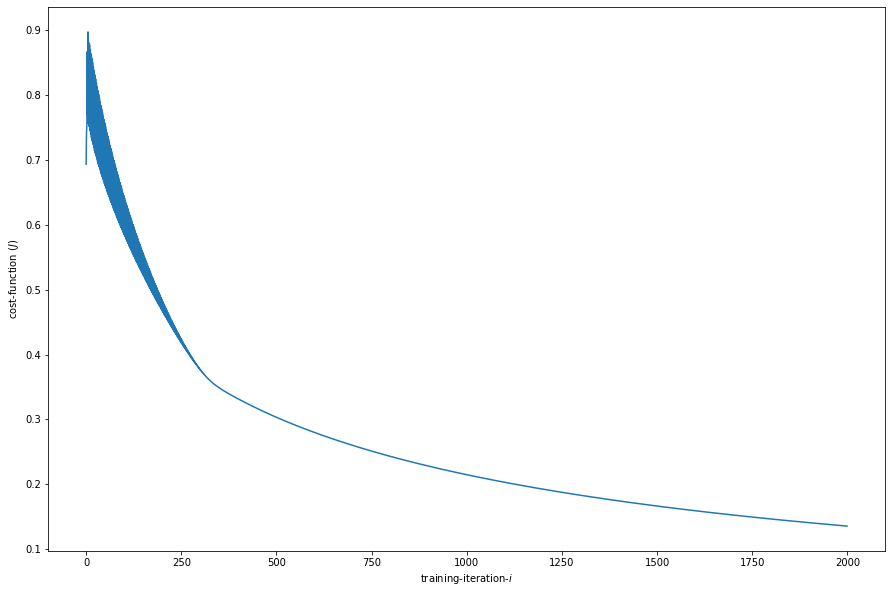

In [8]:
w, b, debug_data = model(debug=True)

## # further-analysis

### Using mean & variance normalization, for pre-processing the images
See the section titled `# pre-processing train & test sets` this for more information.

**Observation**: the learning happens with significantly less number of iterations, and achieves better performance compared to method-2 (see above cell).

Pre-processing data-set... {method: 1} (mean & variance normalization)
X-train: (12288, 209)
Y-train: (1, 209)
X-test: (12288, 50)
Y-test: (1, 50)


100%|██████████| 400/400 [00:01<00:00, 245.77it/s]


Test accuracy: 72.0%
Train accuracy: 99.52153110047847%


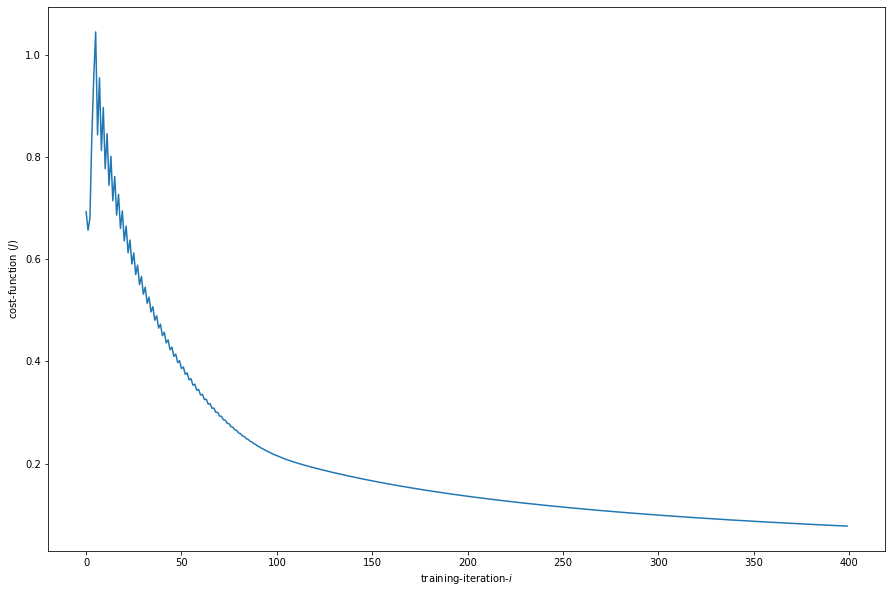

In [8]:
_ = model(debug=True, pre_process_method=1, iterations=400)

### What happens if one uses the squared-error function instead of the log-loss function?
The squred-error function is defined as follows:

$$
J = \frac{1}{m} \sum_{i = 1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

Since, the cost-function is $n_x$ dimensional w.r.t. $\mathbf{w}$, here we will be analyzing the variation in the cost w.r.t. to $b$ (i.e. the bias term).
 - Also, we will be using the $\mathbf{w}$ vector computed above.

 **Observation**: the squred-error cost-function shows multiple local-minima, but the log-loss function doesn't

X-train: (12288, 209)
Y-train: (1, 209)
X-test: (12288, 50)
Y-test: (1, 50)
optimal-b: -0.015906243999692968


C:\Users\Harsha\AppData\Local\Temp/ipykernel_2172/2317503552.py:13: RuntimeWarning: divide by zero encountered in log
  l = -1 * Y * np.log(a) - (1 - Y) * np.log(1 - a)
C:\Users\Harsha\AppData\Local\Temp/ipykernel_2172/2317503552.py:13: RuntimeWarning: invalid value encountered in multiply
  l = -1 * Y * np.log(a) - (1 - Y) * np.log(1 - a)


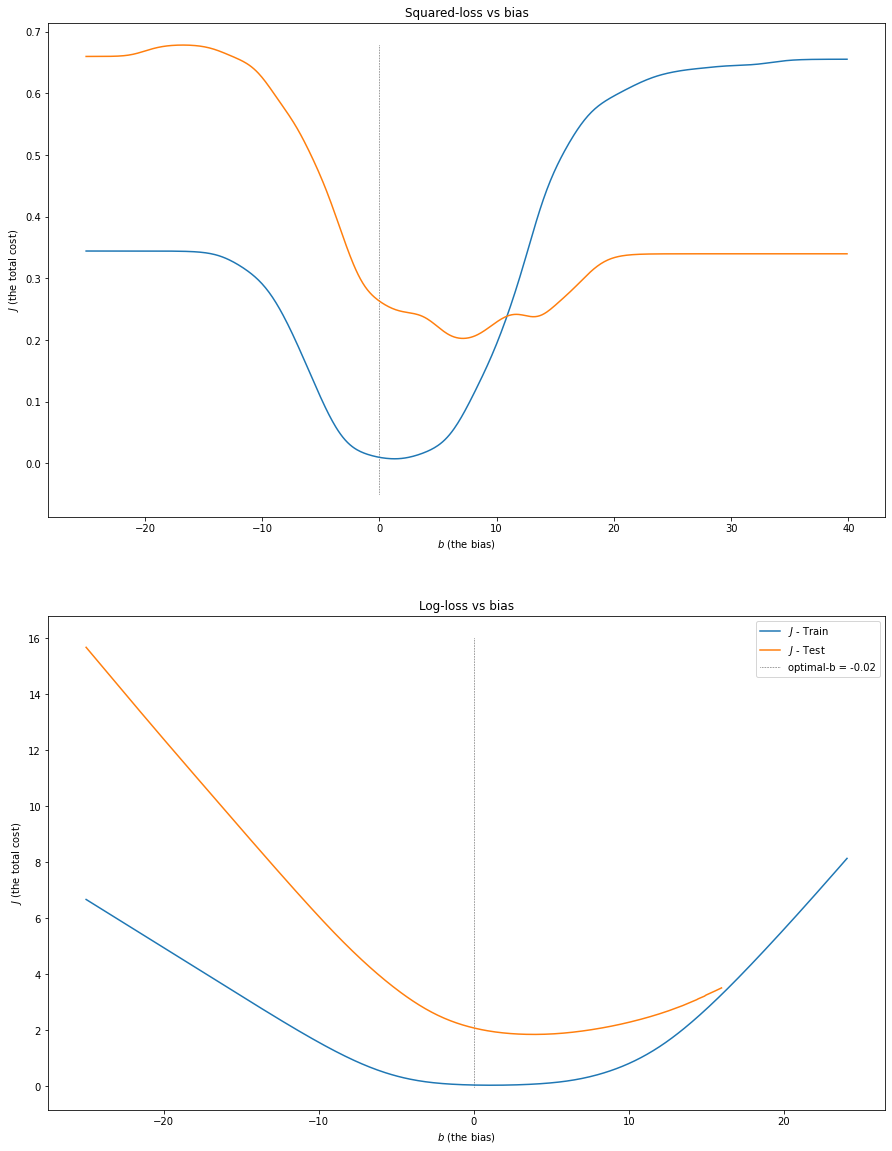

In [184]:
X_train, Y_train, X_test, Y_test = pre_process(method=1)

nb = np.arange(start=b - 25, stop=b + 40, step=0.1).reshape((-1, 1))
print(f"optimal-b: {b}")

def squared_cost(X, Y, w, nd_b):
    a = 1 / np.float64(1 + np.exp(-np.dot(w.T, X) - nd_b))
    J = np.mean(np.power(a - Y, 2), axis=1)
    return J

def log_cost(X, Y, w, nd_b):
    a = forward_propagation(X, w, nd_b)
    l = -1 * Y * np.log(a) - (1 - Y) * np.log(1 - a)
    J = np.mean(l, axis=1)
    return J

J_sqrd_train = squared_cost(X_train, Y_train, w, nb)
J_sqrd_test = squared_cost(X_test, Y_test, w, nb)

J_log_train = log_cost(X_train, Y_train, w, nb)
J_log_test = log_cost(X_test, Y_test, w, nb)

fig, axs = plt.subplots(2, 1, figsize=(15, 20))
axs[0].set_title("Squared-loss vs bias")
axs[0].plot(nb, J_sqrd_train, label="$J$ - Train")
axs[0].plot(nb, J_sqrd_test, label="$J$ - Test")
axs[0].vlines(b, ymin=-0.05, ymax=np.amax(J_sqrd_test), colors='black',
            linestyles='dotted', linewidths=0.6, 
            label=f"optimal-b = {np.round(b, 2)}")

axs[1].set_title("Log-loss vs bias")
axs[1].plot(nb, J_log_train, label="$J$ - Train")
axs[1].plot(nb, J_log_test, label="$J$ - Test")
axs[1].vlines(b, ymin=-0.05, ymax=16, colors='black',
            linestyles='dotted', linewidths=0.6, 
            label=f"optimal-b = {np.round(b, 2)}")

for ax in axs:
    ax.set_ylabel("$J$ (the total cost)")
    ax.set_xlabel("$b$ (the bias)")

plt.legend()
plt.show()